In [1]:
class state:
    """
    state 에는 agent_sum과 dealer_sum의 쌍이 고유번호로 주어진다.
    각 상태에는 방문횟수,상태의 value값 , 상태에서의 agent가 취하는 액션 확률 집합이 주이진다.
    """
    const_n = 100
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
        self.cnt = 0
        # initial policy
        self.action_p = [0.5,0.5]
        self.action_cnt = {"stick":0,"hit":0}
        # Q(s,a) state s에서 action a를 선택했을 때 reward
        self.Q = {"stick":0 , "hit":0}
        self.value = max(self.Q.values())
        
        ### self.action_alpha ={"stick":0,"hit":0}
        
    def __repr__(self):
        return "(x : {x}, y : {y}, v : {value} a : {action})".format(x=self.x,y=self.y,value = self.value, action =self.greedy_action())

    
    def p_setter(self):
        e = self.const_n/(self.const_n+self.cnt)
        max_a = max(self.Q,key = self.Q.get)
        self.action_p = [e/2,1-e/2] if max_a == "stick" else [1 - e/2 , e/2]
    
    """
    #  since alpha = 1/action_cnt[action]
    def alpha_setter(self,action):
        self.action_alpha[action] = 1/self.action_cnt[action]
    """
    
    def Q_setter(self,action,reward):
        Q_value = self.Q[action]
        Q_cnt = self.action_cnt[action]
        
        self.Q[action] = Q_value + (reward - Q_value)/Q_cnt
        
    def greedy_action(self):
        greedy_a = max(self.Q,key = self.Q.get)
        return greedy_a
        
    @staticmethod
    def state_update(episode,reward):
        state = episode.state
        action = episode.action
        
        state.cnt += 1
        state.action_cnt[action] += 1
        # state.alpah_setter(action)

        state.Q_setter(action,reward)
        state.p_setter()
        
        state.value = max(state.Q.values())
        
            

In [2]:
states_list = [[state(x,y) for y in range(1,22)] for x in range(1,22)]

class agent:
    """
    agent는 현재상태를 알고 있다.
    액션은 두가지이다.
    모든 상태에 대한 value값과 cnt값 action_p를 계산한다.
    """
    
    def __init__(self,state):
        self.action = ["stick","hit"]
        x,y = state
        self._current_state = states_list[x-1][y-1]
        
        
    # 플레이어의 액션 집합. 
    # 입실론 그리디하게 액션을 선택한다.
    @property
    def current_state(self):
        return self._current_state
    @current_state.setter
    def current_state(self,state):
        x,y = state
        self._current_state = states_list[x-1][y-1]
    
    @property
    def e_agent_action(self):
        from numpy.random import choice
        return choice(self.action,p = self._current_state.action_p)
    

In [3]:
class card_game:
    
    def __init__(self):
        self.card = [ i for i in range(-10,0)] + [i for i in range(1,11) for a in range(2)]
        
        
    # 첫 번째 블랙 카드 랜덤 배정.
    
    @staticmethod
    def get_first_card():
        import random
        black_card = [i for i in range(1,11)]
        choice1 = random.choice(black_card)
        choice2 = random.choice(black_card)
        return choice1, choice2
    
    
    # 카드를 랜덤하게 배정한다 검정 카드는 2/3의 확률로 , 빨간 카드는 1/3의 확률로 나눠줌.
    def get_card(self):
        import random
        return random.choice(self.card)

    # 검정 카드의 빈도가 2/3의 확률 비율을 갖는지 검정한다.
    # 그냥 해봤다. 재밌었음. 랜덤하게 배정하는 원리는 무엇인가.
    def one_proportion_test(self,testcase=10000):
        tc = {"black" : 0,"red":0}
        for i in range(testcase):
            a = self.get_card()
            if a > 0 :
                tc["black"]+=1
            else:
                tc["red"] +=1
        print(' # of cases : {number}'.format(number = testcase))
        print(' # of black : {black}\n # of red   : {red}'.format(black = tc["black"],red = tc["red"]))
        
        returned = tc["black"]
        installs = tc["black"] + tc["red"]
        from statsmodels.stats.proportion import proportions_ztest
        z,p = proportions_ztest(returned, installs, value=2/3, alternative='smaller')
        print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))
        
        from statsmodels.stats.proportion import proportion_confint 
        ci_low, ci_upp = proportion_confint(returned, installs)
        print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'.format(100*ci_low, 100*ci_upp))
        
    
    
    def step(self,state,action):
        reward = None
        agent_sum,dealer_sum = state.x,state.y
        next_state = (state.x,state.y)

        # agent's action and next state
        if action == "hit":
            agent_sum += self.get_card()
            if agent_sum > 21 or agent_sum < 1:
                reward = -1
                return _,reward
        
        #dealer's action and next state
        if dealer_sum >= 17:
            if action == "stick":
                if agent_sum == dealer_sum:
                    reward = 0
                elif agent_sum > dealer_sum:
                    reward = 1
                else:
                    reward = -1
        else:
            dealer_sum += self.get_card()
            if dealer_sum >21 or dealer_sum <1:
                reward = 1
    
    
        next_state = (agent_sum,dealer_sum)
        return next_state,reward
    
    

In [4]:
class Episode:
    def __init__(self,state,action):
        self.state = state
        self.action = action
        # episode = (state,action)
        
    def __repr__(self):
        return " # ep : (state : %r , action : %r"%(self.state,self.action)
    

In [5]:
# 카드게임 테스트용 
a = card_game()

In [6]:
# 카드 게임 공정성 판단.
# 카드 배분이 랜덤하게 잘 배분되는지 비율을 검증한다.
# 검증 완료 p_value 값이 충분하여 H0 : p = 2/3을 기각하지 못한다.
a.one_proportion_test()

 # of cases : 10000
 # of black : 6658
 # of red   : 3342
 z-stat = -0.1837286885485429 
 p-value = 0.4271131509000116
 95% Confidence Interval = ( 65.66% , 67.50% )


In [7]:
# 진짜 게임 시작
iterate_time = 50000# 에피소드 반복 횟수를 설정해줘야함.  

In [8]:
game = card_game()
episodes= []

for i in range(iterate_time):
    # 첫번째 카드를 받는다.
    player = agent(game.get_first_card())
    episode_list = []
    i = 1
    while True:
        # agent의 action을 정한다. 
        # e_greedy하게 action을 선택한다.
        action = player.e_agent_action

        # episode에 업데이트 한다.
        episode_list.append(Episode(player.current_state,action))

        # 게임을 진행한다.
        # 1 step은 딜러와 플레이어의 액션이 동시에 진행된다.
        # 보상은 그에 따라 주어진 결과에 의해서 반영된다.
        next_state,reward = game.step(player.current_state,action)

        # update current state
        if reward is not None:
            break
            
        player.current_state = next_state
        
        
    for ep in episode_list:
        state.state_update(ep,reward)
        
    episodes.append(episode_list)
    
# end가 프린트 되면 성
print("end")

end


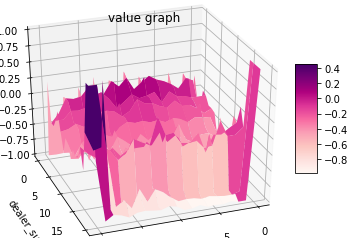

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def fun(x, y):
    return states_list[x-1][y-1].value

x = y = np.arange(0, 21, 1)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')              # 3d axes instance

surf = ax.plot_surface(X, Y, Z,           # data values (2D Arryas)
                       rstride=2,                    # row step size
                       cstride=2,                   # column step size
                       cmap=cm.RdPu,        # colour map
                       linewidth=1,                # wireframe line width
                       antialiased=True)

ax.set_title('value graph')        # title
ax.set_xlabel('agent_sum')                             # x label
ax.set_ylabel('dealer_sum')                             # y label
ax.set_zlabel('value')                             # z label
fig.colorbar(surf, shrink=0.5, aspect=5)   # colour bar
 
ax.view_init(elev=30,azim=70)                # elevation & angle
ax.dist=8                                                  # distance from the plot
plt.show()


In [9]:
# GLIE 확인
states_list[3][3].action_p

[0.007660487206986364, 0.9923395127930137]

In [15]:
states_list[20][19]

(x : 21, y : 20, v : 1.0 a : stick)